## Settings for the website and import of the API key, API key was stored locally using PowerShell

In [ ]:
import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

BASE_URL = "https://api.eia.gov/v2/electricity/rto/region-data/data/"

api_key = os.getenv("EIA_API_KEY")

if not api_key:
    raise RuntimeError(
        "Missing EIA_API_KEY.\n"
        "Set it before launching Jupyter and restart the Jupyter server."
    )

print("EIA_API_KEY found. Length:", len(api_key))

#  Public API key that we were given: "6xe95RiwN2boxwGicLxMsNF2cksLy1LBwkRmTybj" 


EIA_API_KEY found. Length: 40


## Settings for the website, we were looking for Texas from January 1st 2022 till January 1st 2025, and we wanted hourly demand

In [26]:
RESPONDENT = "ERCOT"     # Texas
TYPES = ("D", "DF")      # Actual demand + Day-ahead forecast
FREQUENCY = "hourly"

START = "2022-01-01T00"
END   = "2025-01-01T00"

PAGE_LEN = 5000
SLEEP_S  = 0.15

RESPONDENT, TYPES, START, END


('ERCOT', ('D', 'DF'), '2022-01-01T00', '2025-01-01T00')

## Data Ingestion – EIA API Pagination Function

This function implements a reusable data ingestion layer for automatically retrieving ERCOT electricity demand data from the U.S. Energy Information Administration (EIA) API
The EIA API limits the number of records that can be returned in a single request. To handle this, the function downloads the dataset in multiple pages using offset–length pagination. Each request retrieves a sorted slice of the time series data, ensuring that large datasets can be collected safely and reliably.
It then sends the request to the EIA endpoint, validates the HTTP response, parses the JSON payload, and extracts the relevant data rows.

In [27]:
def fetch_page(
    api_key: str,
    respondent: str,
    types: tuple[str, ...],
    start: str,
    end: str,
    frequency: str,
    offset: int,
    length: int
) -> list[dict]:
    """
    Fetch one page from EIA v2. Returns list of dict rows (may be empty).
    """
    params = {
        "api_key": api_key,
        "frequency": frequency,
        "data[0]": "value",
        "start": start,
        "end": end,
        "offset": offset,
        "length": length,
        "sort[0][column]": "period",
        "sort[0][direction]": "asc",
        "facets[respondent][0]": respondent,
    }
    for i, t in enumerate(types):
        params[f"facets[type][{i}]"] = t

    r = requests.get(BASE_URL, params=params, timeout=60)
    r.raise_for_status()
    payload = r.json()

    return payload.get("response", {}).get("data", [])


## Automated Full Dataset Download

This function controls the complete extraction of ERCOT electricity demand data from the EIA API by repeatedly calling the pagination function.
Because the EIA API only returns a limited number of observations per request, the function loops through all available result pages using an increasing offset value. 
The loop terminates automatically when no further records are found or when the last partial page is reached. A short pause between requests is included to prevent overloading the API service.
Finally, all retrieved records are added into a single structured pandas DataFrame, forming the raw historical dataset that is later used for data cleaning, aggregation, and forecasting.

In [28]:
def fetch_all(
    api_key: str,
    respondent: str,
    types: tuple[str, ...],
    start: str,
    end: str,
    frequency: str = "hourly",
    page_len: int = 5000,
    sleep_s: float = 0.15
) -> pd.DataFrame:
    """
    Fetch all pages into a DataFrame. Safe against empty results.
    """
    all_rows = []
    offset = 0

    while True:
        chunk = fetch_page(
            api_key=api_key,
            respondent=respondent,
            types=types,
            start=start,
            end=end,
            frequency=frequency,
            offset=offset,
            length=page_len
        )

        if not chunk:
            break

        all_rows.extend(chunk)
        offset += len(chunk)
        print(f"Fetched {len(chunk):>5} rows | total={offset:>9}", end="\r")

        if len(chunk) < page_len:
            break

        time.sleep(sleep_s)

    print()  # newline after progress
    return pd.DataFrame(all_rows)


## Sample testing with 5000 rows (returned an error)

In [29]:
sample = fetch_all(
    api_key=api_key,
    respondent=RESPONDENT,
    types=TYPES,
    start="2024-01-01T00",
    end="2024-01-08T00",
    frequency=FREQUENCY,
    page_len=5000
)

print("Sample rows:", len(sample))
sample.head()



Sample rows: 0


""


## In the blocks below we have been fixing the mistake of finding the right respondent for Texas state which ended up being "ERCO" instead of "ERCOT"

In [31]:
import requests, os, pandas as pd

BASE_URL = "https://api.eia.gov/v2/electricity/rto/region-data/data/"

params = {
    "api_key": os.getenv("EIA_API_KEY"),
    "frequency": "hourly",
    "data[0]": "value",
    "start": "2024-01-01T00",
    "end": "2024-01-03T00",
    "length": 200,          # small sample
    "facets[type][0]": "D" # actual demand only
}

r = requests.get(BASE_URL, params=params, timeout=60)
r.raise_for_status()

df_tmp = pd.DataFrame(r.json()["response"]["data"])
df_tmp[["respondent", "type", "period", "value"]].head(10)


,respondent,type,period,value
0,AECI,D,2024-01-03T00,3284
1,AVA,D,2024-01-03T00,1710
2,AZPS,D,2024-01-03T00,3108
3,BANC,D,2024-01-03T00,2087
4,BPAT,D,2024-01-03T00,8057
5,CAL,D,2024-01-03T00,29179
6,CAR,D,2024-01-03T00,30755
7,CENT,D,2024-01-03T00,33844
8,CHPD,D,2024-01-03T00,302
9,CISO,D,2024-01-03T00,23720


In [33]:
df_tmp["respondent"].value_counts().index.tolist()



['AECI',
 'AVA',
 'AZPS',
 'BANC',
 'BPAT',
 'CAL',
 'CAR',
 'CENT',
 'CHPD',
 'CISO',
 'CPLE',
 'CPLW',
 'DOPD',
 'DUK',
 'EPE',
 'ERCO',
 'FLA',
 'FMPP',
 'FPC',
 'FPL',
 'GCPD',
 'GVL',
 'HST',
 'IID',
 'IPCO',
 'ISNE',
 'JEA',
 'LDWP',
 'LGEE',
 'MIDA',
 'MIDW',
 'MISO',
 'NE',
 'NEVP',
 'NW',
 'NWMT',
 'NY',
 'NYIS',
 'PACE',
 'PACW',
 'PGE',
 'PJM',
 'PNM',
 'PSCO',
 'PSEI',
 'SC',
 'SCEG',
 'SCL',
 'SE',
 'SEC',
 'SOCO',
 'SPA',
 'SRP',
 'SW',
 'SWPP',
 'TAL',
 'TEC',
 'TEN',
 'TEPC',
 'TEX',
 'TIDC',
 'TPWR',
 'TVA',
 'US48',
 'WACM',
 'WALC',
 'WAUW']

## Testing with new respondent (success)

In [ ]:
params = {
    "api_key": os.getenv("EIA_API_KEY"),
    "frequency": "hourly",
    "data[0]": "value",
    "facets[respondent][0]": "ERCO", 
    "facets[type][0]": "D",
    "start": "2024-01-01T00",
    "end": "2024-01-08T00",
    "length": 200,
    "sort[0][column]": "period",
    "sort[0][direction]": "asc",
}

r = requests.get(BASE_URL, params=params, timeout=60)
r.raise_for_status()

df_tx = pd.DataFrame(r.json()["response"]["data"])
df_tx["period"] = pd.to_datetime(df_tx["period"], utc=True)
df_tx["value"] = pd.to_numeric(df_tx["value"])

len(df_tx), df_tx.head()


(169,
                      period respondent                              respondent-name type type-name  value    value-units
 0 2024-01-01 00:00:00+00:00       ERCO  Electric Reliability Council of Texas, Inc.    D    Demand  44394  megawatthours
 1 2024-01-01 01:00:00+00:00       ERCO  Electric Reliability Council of Texas, Inc.    D    Demand  45855  megawatthours
 2 2024-01-01 02:00:00+00:00       ERCO  Electric Reliability Council of Texas, Inc.    D    Demand  44887  megawatthours
 3 2024-01-01 03:00:00+00:00       ERCO  Electric Reliability Council of Texas, Inc.    D    Demand  44012  megawatthours
 4 2024-01-01 04:00:00+00:00       ERCO  Electric Reliability Council of Texas, Inc.    D    Demand  43279  megawatthours)

## Successful fetch which has failed above

In [35]:
def fetch_all_erco(
    start="2022-01-01T00",
    end="2025-01-01T00",
    page_len=5000,
    sleep_s=0.15
):
    all_rows = []
    offset = 0

    while True:
        params = {
            "api_key": os.getenv("EIA_API_KEY"),
            "frequency": "hourly",
            "data[0]": "value",
            "facets[respondent][0]": "ERCO",
            "facets[type][0]": "D",   # actual demand
            "start": start,
            "end": end,
            "offset": offset,
            "length": page_len,
            "sort[0][column]": "period",
            "sort[0][direction]": "asc",
        }

        r = requests.get(BASE_URL, params=params, timeout=60)
        r.raise_for_status()
        chunk = r.json()["response"]["data"]

        if not chunk:
            break

        all_rows.extend(chunk)
        offset += len(chunk)
        print(f"Fetched {len(chunk):>5} rows | total={offset:>8}", end="\r")

        if len(chunk) < page_len:
            break

        time.sleep(sleep_s)

    print()
    return pd.DataFrame(all_rows)


df_raw = fetch_all_erco()
print("Total rows:", len(df_raw))
df_raw.head()


Fetched  1305 rows | total=   26305
Total rows: 26305


,period,respondent,respondent-name,type,type-name,value,value-units
0,2022-01-01T00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,45943,megawatthours
1,2022-01-01T01,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,46427,megawatthours
2,2022-01-01T02,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,45058,megawatthours
3,2022-01-01T03,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,43430,megawatthours
4,2022-01-01T04,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,42058,megawatthours


# We decided to store the data that we fetched into our local folder so we can always have access to it and it is easier to work with csv and parquet files

In [36]:
df = df_raw.copy()
df["period"] = pd.to_datetime(df["period"], utc=True)
df["value"] = pd.to_numeric(df["value"], errors="coerce")

df = df.dropna(subset=["period", "value"]).sort_values("period").reset_index(drop=True)

import os
os.makedirs("data/raw", exist_ok=True)

df.to_csv("data/raw/ercot_hourly_demand.csv", index=False)
df.to_parquet("data/raw/ercot_hourly_demand.parquet", index=False)

df.head()


,period,respondent,respondent-name,type,type-name,value,value-units
0,2022-01-01 00:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,45943,megawatthours
1,2022-01-01 01:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,46427,megawatthours
2,2022-01-01 02:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,45058,megawatthours
3,2022-01-01 03:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,43430,megawatthours
4,2022-01-01 04:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,42058,megawatthours


## Daily Aggregation

We aggregated the hourly ERCOT demand data into daily averages by resampling the time series and computing the mean daily electricity demand, creating the final daily demand dataset used for modeling.

In [ ]:
daily = (
    df
    .set_index("period")
    .resample("D")["value"]
    .mean()
    .to_frame(name="demand_mwh")
    .reset_index()
)

daily.head(), len(daily)


(                     period    demand_mwh
 0 2022-01-01 00:00:00+00:00  40121.541667
 1 2022-01-02 00:00:00+00:00  46532.500000
 2 2022-01-03 00:00:00+00:00  49912.791667
 3 2022-01-04 00:00:00+00:00  46539.875000
 4 2022-01-05 00:00:00+00:00  41677.875000,
 1097)

## Saving Proccesed Data

We created the processed data directory and saved the final daily demand dataset in both CSV and Parquet formats for reuse in modeling and forecasting.

In [38]:
os.makedirs("data/processed", exist_ok=True)

daily.to_csv("data/processed/ercot_daily_demand.csv", index=False)
daily.to_parquet("data/processed/ercot_daily_demand.parquet", index=False)


## Exploratory Visualization

We plotted daily electricity demand over time to visualize long-term trends, seasonality, and abnormal demand periods in Texas.

<Axes: title={'center': 'ERCOT (Texas) Daily Electricity Demand'}, xlabel='period'>

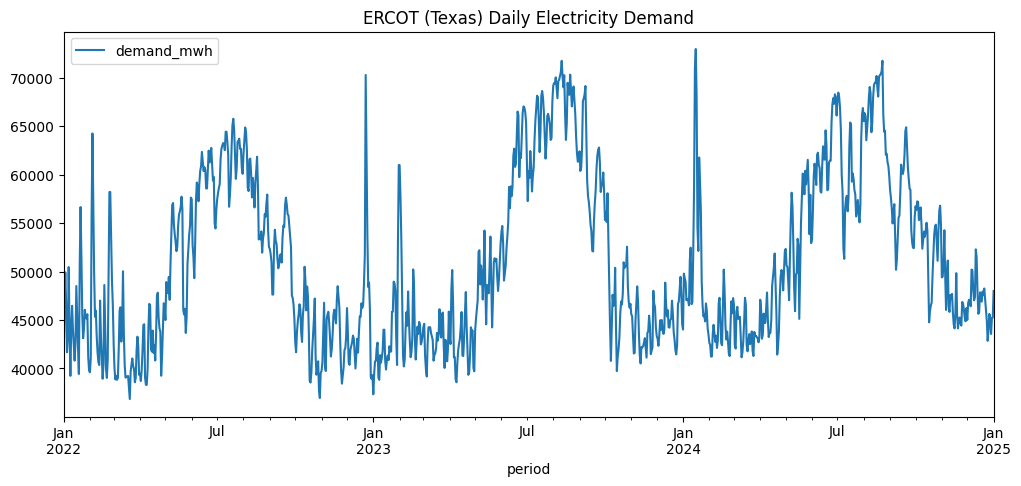

In [39]:
daily.plot(
    x="period",
    y="demand_mwh",
    figsize=(12,5),
    title="ERCOT (Texas) Daily Electricity Demand"
)


Daily electricity demand typically ranges between 40,000 and 55,000 MWh during winter and spring periods.
During summer months, demand regularly rises to 65,000–72,000 MWh, showing strong cooling-driven seasonality.
The highest observed peaks exceed 70,000 MWh, indicating extreme load conditions caused by heat waves or unusual weather events.
Low-demand periods drop to around 38,000–42,000 MWh, which represent baseline system usage.
The overall baseline demand level increases slightly from 2022 to 2024, suggesting a gradual long-term growth in electricity consumption in Texas.

<Axes: title={'center': 'Average Demand by Day of Week'}, xlabel='dow'>

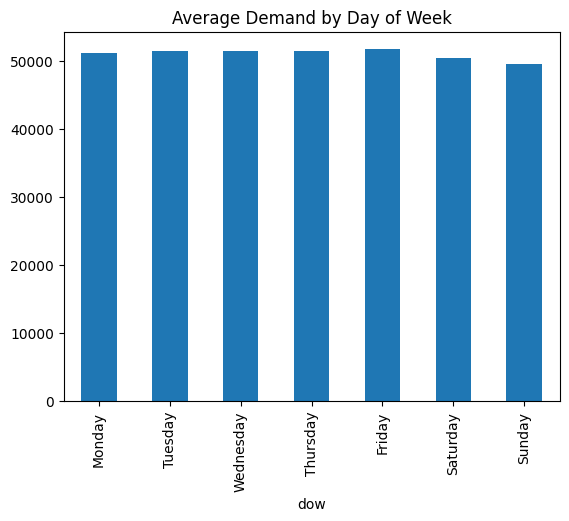

In [40]:
daily["dow"] = daily["period"].dt.day_name()
daily.groupby("dow")["demand_mwh"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).plot(kind="bar", title="Average Demand by Day of Week")



## Train / Test Split

We split the dataset into a training set with 730 daily observations (2022–2023) and a test set with 367 daily observations (2024) to evaluate how well the model predicts unseen future data.


In [ ]:
train = daily[daily["period"] < "2024-01-01"].copy()
test  = daily[daily["period"] >= "2024-01-01"].copy()

train.shape, test.shape


((730, 3), (367, 3))

## Naïve Baseline Forecast
We created a simple baseline model that predicts all future values using the last observed demand from the training period, serving as a reference to measure how much our advanced models improve over a basic assumption.

In [43]:
# Naïve forecast: y_hat(t) = y(t-1)

naive_forecast = test.copy()
naive_forecast["y_hat"] = train["demand_mwh"].iloc[-1]

naive_forecast.head()


,period,demand_mwh,dow,y_hat
730,2024-01-01 00:00:00+00:00,44014.000000,Monday,44543.708333
731,2024-01-02 00:00:00+00:00,49782.208333,Tuesday,44543.708333
732,2024-01-03 00:00:00+00:00,49304.583333,Wednesday,44543.708333
733,2024-01-04 00:00:00+00:00,48952.791667,Thursday,44543.708333
734,2024-01-05 00:00:00+00:00,47032.333333,Friday,44543.708333


## Seasonal Naïve Baseline

We created a seasonal baseline model that predicts each day’s demand using the value from 7 days earlier, capturing weekly consumption patterns and providing a stronger benchmark than the simple naïve forecast.

In [44]:
# Seasonal naïve: y_hat(t) = y(t-7)

seasonal_naive = test.copy()

seasonal_naive["y_hat"] = (
    daily
    .set_index("period")["demand_mwh"]
    .shift(7)
    .loc[test["period"]]
    .values
)

seasonal_naive.head(10)


,period,demand_mwh,dow,y_hat
730,2024-01-01 00:00:00+00:00,44014.000000,Monday,42391.250000
731,2024-01-02 00:00:00+00:00,49782.208333,Tuesday,46634.083333
732,2024-01-03 00:00:00+00:00,49304.583333,Wednesday,46909.166667
733,2024-01-04 00:00:00+00:00,48952.791667,Thursday,48094.666667
734,2024-01-05 00:00:00+00:00,47032.333333,Friday,49451.833333
735,2024-01-06 00:00:00+00:00,47179.375000,Saturday,47554.416667
736,2024-01-07 00:00:00+00:00,47042.000000,Sunday,44543.708333
737,2024-01-08 00:00:00+00:00,46513.416667,Monday,44014.000000
738,2024-01-09 00:00:00+00:00,51205.166667,Tuesday,49782.208333
739,2024-01-10 00:00:00+00:00,52459.625000,Wednesday,49304.583333


## Baseline Model Evaluation

We evaluated the naïve and seasonal naïve models using MAE and RMSE. The seasonal naïve model performed significantly better, reducing the MAE from about 8,748 MWh to 4,057 MWh, showing the importance of capturing weekly demand patterns.

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def eval_forecast(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

metrics_naive = eval_forecast(
    test["demand_mwh"],
    naive_forecast["y_hat"]
)

metrics_seasonal = eval_forecast(
    test["demand_mwh"],
    seasonal_naive["y_hat"]
)

metrics_naive, metrics_seasonal


({'MAE': 8747.811762034513, 'RMSE': np.float64(11597.374322444211)},
 {'MAE': 4057.289963669391, 'RMSE': np.float64(5639.454746378061)})

##  Baseline Forecast Comparison

We plotted the actual 2024 demand against the naïve and seasonal naïve forecasts to visually compare their performance, showing that the seasonal naïve model follows the real demand pattern much better than the simple constant naïve baseline.

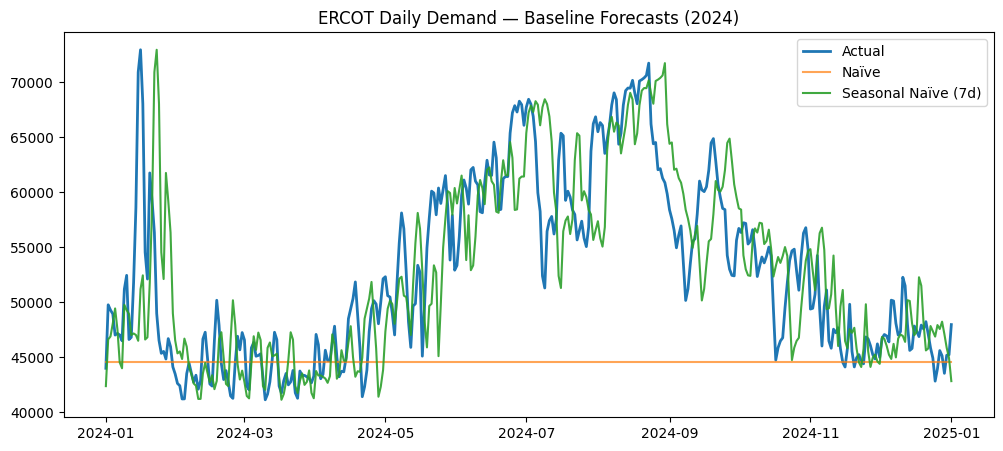

In [46]:
plt.figure(figsize=(12,5))
plt.plot(test["period"], test["demand_mwh"], label="Actual", linewidth=2)
plt.plot(test["period"], naive_forecast["y_hat"], label="Naïve", alpha=0.7)
plt.plot(test["period"], seasonal_naive["y_hat"], label="Seasonal Naïve (7d)", alpha=0.9)
plt.legend()
plt.title("ERCOT Daily Demand — Baseline Forecasts (2024)")
plt.show()


## Baseline Forecasting & Evaluation

We compared two simple benchmark models — a constant naïve model and a seasonal naïve (7-day lag) model — against real 2024 demand. The seasonal naïve model follows the real demand pattern much better and reduces the MAE from 8,748 MWh to 4,057 MWh, proving that weekly seasonality is a key driver of electricity demand.

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

metrics_naive = metrics(
    test["demand_mwh"],
    naive_forecast["y_hat"]
)

metrics_seasonal = metrics(
    test["demand_mwh"],
    seasonal_naive["y_hat"]
)

metrics_naive, metrics_seasonal


({'MAE': 8747.811762034513, 'RMSE': np.float64(11597.374322444211)},
 {'MAE': 4057.289963669391, 'RMSE': np.float64(5639.454746378061)})

## XGBoost

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Feature Engineering for XGBoost

We created predictive features from the time series, including calendar variables (day of week, month, weekend flag), lagged demand values (1, 7, 14, 28 days), and rolling averages (7, 14, 28 days). All rolling features are shifted to prevent data leakage and ensure that only past information is used for prediction.

In [51]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("period").copy()
    df["dow"] = df["period"].dt.dayofweek
    df["month"] = df["period"].dt.month
    df["is_weekend"] = (df["dow"] >= 5).astype(int)

    # lags
    for lag in [1, 7, 14, 28]:
        df[f"lag_{lag}"] = df["demand_mwh"].shift(lag)

    # rolling means (use shifted series to avoid leakage)
    df["roll7_mean"]  = df["demand_mwh"].shift(1).rolling(7).mean()
    df["roll14_mean"] = df["demand_mwh"].shift(1).rolling(14).mean()
    df["roll28_mean"] = df["demand_mwh"].shift(1).rolling(28).mean()

    return df

feat = make_features(daily)

# drop rows where features are NaN (early days due to lags)
feat = feat.dropna().reset_index(drop=True)

feat.head()


,period,demand_mwh,dow,month,is_weekend,lag_1,lag_7,lag_14,lag_28,roll7_mean,roll14_mean,roll28_mean
0,2022-01-29 00:00:00+00:00,45589.000000,5,1,1,45158.625000,51467.833333,42695.875000,40121.541667,45799.738095,46134.815476,45198.180060
1,2022-01-30 00:00:00+00:00,41239.625000,6,1,1,45589.000000,45520.916667,48501.750000,46532.500000,44959.904762,46341.467262,45393.446429
2,2022-01-31 00:00:00+00:00,39815.583333,0,1,0,41239.625000,43114.541667,45132.875000,49912.791667,44348.291667,45822.744048,45204.415179
3,2022-02-01 00:00:00+00:00,39607.166667,1,2,0,39815.583333,44043.708333,42156.708333,46539.875000,43877.011905,45442.937500,44843.800595
4,2022-02-02 00:00:00+00:00,41030.416667,2,2,0,39607.166667,46052.583333,39425.583333,41677.875000,43243.220238,45260.827381,44596.203869


## Feature-Based Train / Test Split

We split the engineered feature dataset into training (702 days before 2024) and testing (367 days in 2024) sets, and separated input features from the target demand variable to prepare the data for XGBoost model training and evaluation.

In [52]:
cutoff = pd.Timestamp("2024-01-01", tz="UTC") if daily["period"].dt.tz is not None else pd.Timestamp("2024-01-01")

train_feat = feat[feat["period"] < cutoff].copy()
test_feat  = feat[feat["period"] >= cutoff].copy()

feature_cols = [c for c in train_feat.columns if c not in ["period", "demand_mwh"]]

X_train = train_feat[feature_cols]
y_train = train_feat["demand_mwh"]

X_test = test_feat[feature_cols]
y_test = test_feat["demand_mwh"]

len(X_train), len(X_test), feature_cols[:10]


(702,
 367,
 ['dow',
  'month',
  'is_weekend',
  'lag_1',
  'lag_7',
  'lag_14',
  'lag_28',
  'roll7_mean',
  'roll14_mean',
  'roll28_mean'])

## XGBoost Model Training

We trained an XGBoost regression model using engineered time-series features to learn nonlinear demand patterns, and then generated demand predictions for the 2024 test period.

In [53]:
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
)

xgb.fit(X_train, y_train)

yhat_test = xgb.predict(X_test)


## Model Evaluation & Comparison

We aligned the predictions in time and compared the seasonal naïve baseline with the XGBoost model. XGBoost significantly improves accuracy, reducing MAE from 4,057 MWh to 2,027 MWh and RMSE from 5,639 MWh to 2,722 MWh, demonstrating its superior predictive performance.

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


seasonal_naive = test.copy()
seasonal_naive["y_hat"] = (
    daily.set_index("period")["demand_mwh"]
         .shift(7)
         .loc[test["period"]]
         .values
)

# Align indices (because feat dropna removed first rows)
test_aligned = test_feat[["period"]].copy()
test_aligned["actual"] = y_test.values
test_aligned["xgb"] = yhat_test

# seasonal naive aligned to same dates
sn = seasonal_naive.set_index("period").loc[test_aligned["period"], "y_hat"].values
test_aligned["seasonal_naive"] = sn

metrics_table = pd.DataFrame({
    "Model": ["Seasonal Naïve (t-7)", "XGBoost (lags+calendar)"],
    "MAE": [
        mean_absolute_error(test_aligned["actual"], test_aligned["seasonal_naive"]),
        mean_absolute_error(test_aligned["actual"], test_aligned["xgb"]),
    ],
    "RMSE": [
        rmse(test_aligned["actual"], test_aligned["seasonal_naive"]),
        rmse(test_aligned["actual"], test_aligned["xgb"]),
    ],
})

metrics_table


,Model,MAE,RMSE
0,Seasonal Naïve (t-7),4057.289964,5639.454746
1,XGBoost (lags+calendar),2027.439529,2721.666462


## Model Prediction Comparison

We plotted the actual 2024 demand together with the seasonal naïve and XGBoost predictions to visually assess model performance, showing that XGBoost tracks real demand patterns more closely and captures peaks and troughs more accurately.

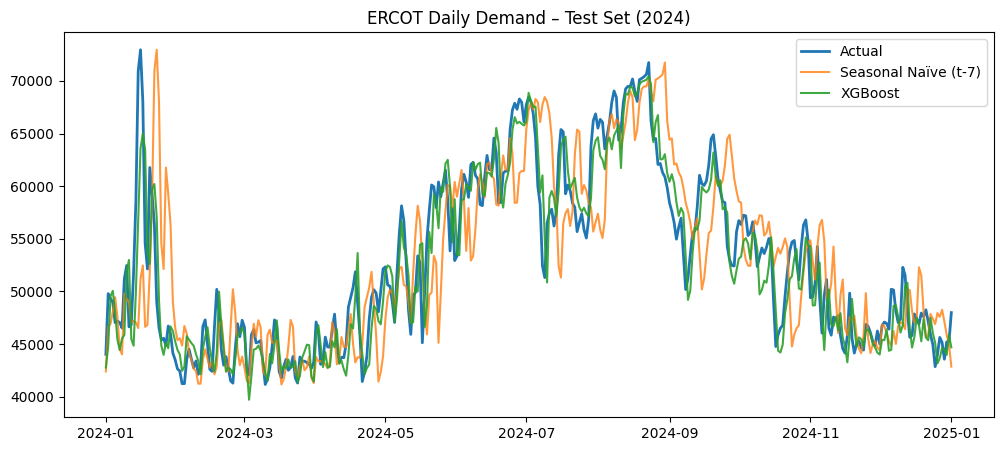

In [55]:
import matplotlib.pyplot as plt

plot_df = test_aligned.set_index("period").copy()

plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["actual"], label="Actual", linewidth=2)
plt.plot(plot_df.index, plot_df["seasonal_naive"], label="Seasonal Naïve (t-7)", alpha=0.8)
plt.plot(plot_df.index, plot_df["xgb"], label="XGBoost", alpha=0.9)
plt.title("ERCOT Daily Demand – Test Set (2024)")
plt.legend()
plt.show()


## Final Model Training

We retrained the XGBoost model on all available historical data up to January 2025 to build the final forecasting model that is later used to generate 2026 demand predictions.

In [56]:
train_end = pd.Timestamp("2025-01-01", tz="UTC") if daily["period"].dt.tz is not None else pd.Timestamp("2025-01-01")

feat_all = make_features(daily).dropna().reset_index(drop=True)
train_all = feat_all[feat_all["period"] < train_end].copy()

X_all = train_all[feature_cols]
y_all = train_all["demand_mwh"]

xgb_full = XGBRegressor(
    n_estimators=900,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
)
xgb_full.fit(X_all, y_all)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


We computed empirical prediction intervals by taking the 5% and 95% quantiles of the XGBoost residuals on the test set (−3,679 to +4,295 MWh), which are later added to the point forecast to form a 90% uncertainty band.

In [ ]:

resid = test_aligned["actual"] - test_aligned["xgb"]

lo_q, hi_q = np.quantile(resid, [0.05, 0.95])
lo_q, hi_q


(np.float64(-3679.9766927083356), np.float64(4295.149088541665))

We generated the 2026 daily forecast by iteratively predicting one day ahead with the trained XGBoost model, updating lag and rolling features after each step so future predictions use previous forecasts. The 90% prediction interval is constructed by adding the empirical residual quantiles (−3,679 and +4,295 MWh) to each point forecast.

In [ ]:
# Build a daily series up to end-2025 to seed lags
series = daily.set_index("period")["demand_mwh"].sort_index().copy()
series = series.asfreq("D").interpolate(limit_direction="both")

start_fc = "2026-01-01"
end_fc   = "2026-12-31"
fc_index = pd.date_range(start=start_fc, end=end_fc, freq="D", tz=series.index.tz)

preds = []

for dt in fc_index:
    # create one-row frame with required fields
    row = pd.DataFrame({"period": [dt], "demand_mwh": [np.nan]})

    # temporary df to compute lags from 'series'
    dow = dt.dayofweek
    month = dt.month
    is_weekend = int(dow >= 5)

    feat_row = {
        "dow": dow,
        "month": month,
        "is_weekend": is_weekend,
        "lag_1": series.get(dt - pd.Timedelta(days=1), np.nan),
        "lag_7": series.get(dt - pd.Timedelta(days=7), np.nan),
        "lag_14": series.get(dt - pd.Timedelta(days=14), np.nan),
        "lag_28": series.get(dt - pd.Timedelta(days=28), np.nan),
        "roll7_mean": series.shift(1).rolling(7).mean().get(dt, np.nan),
        "roll14_mean": series.shift(1).rolling(14).mean().get(dt, np.nan),
        "roll28_mean": series.shift(1).rolling(28).mean().get(dt, np.nan),
    }

    X_row = pd.DataFrame([feat_row])[feature_cols]

    yhat = float(xgb_full.predict(X_row)[0])
    preds.append(yhat)

    # append prediction to series so future lags can use it
    series.loc[dt] = yhat

forecast_2026 = pd.DataFrame({
    "period": fc_index,
    "y_hat": preds,
})

# empirical interval
forecast_2026["lower_90"] = forecast_2026["y_hat"] + lo_q
forecast_2026["upper_90"] = forecast_2026["y_hat"] + hi_q

forecast_2026.head()


,period,y_hat,lower_90,upper_90
0,2026-01-01 00:00:00+00:00,66967.742188,63287.765495,71262.891276
1,2026-01-02 00:00:00+00:00,65698.742188,62018.765495,69993.891276
2,2026-01-03 00:00:00+00:00,61048.437500,57368.460807,65343.586589
3,2026-01-04 00:00:00+00:00,59986.851562,56306.874870,64282.000651
4,2026-01-05 00:00:00+00:00,57035.847656,53355.870964,61330.996745


## Empirical Prediction Interval Estimation

We computed the 5% and 95% quantiles of the XGBoost residual errors on the test set to approximate the uncertainty range of future forecasts and define a 90% empirical prediction interval.

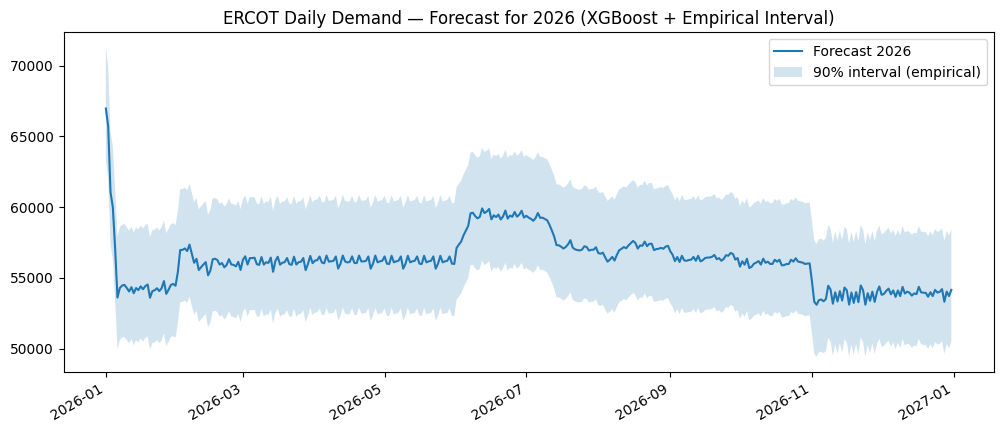

In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))

# line
ax.plot(forecast_2026["period"], forecast_2026["y_hat"], label="Forecast 2026")

# convert datetime to matplotlib date numbers (safe)
x = mdates.date2num(pd.to_datetime(forecast_2026["period"]).dt.tz_convert(None))

ax.fill_between(
    x,
    forecast_2026["lower_90"].values,
    forecast_2026["upper_90"].values,
    alpha=0.2,
    label="90% interval (empirical)"
)

# tell matplotlib the x-axis is dates
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.set_title("ERCOT Daily Demand — Forecast for 2026 (XGBoost + Empirical Interval)")
ax.legend()
fig.autofmt_xdate()
plt.show()


## Export of Final 2026 Forecast Results

We saved the complete 2026 daily forecast together with its lower and upper 90% prediction bounds into CSV and Parquet files so the results can be reused for reporting, dashboards, and further analysis.

In [62]:
import os

os.makedirs("data/forecast", exist_ok=True)

forecast_2026_out = forecast_2026.copy()
forecast_2026_out["period"] = forecast_2026_out["period"].dt.tz_convert(None)

forecast_2026_out.to_csv(
    "data/forecast/ercot_daily_demand_forecast_2026_xgboost.csv",
    index=False
)

forecast_2026_out.to_parquet(
    "data/forecast/ercot_daily_demand_forecast_2026_xgboost.parquet",
    index=False
)

forecast_2026_out.head()


,period,y_hat,lower_90,upper_90
0,2026-01-01,66967.742188,63287.765495,71262.891276
1,2026-01-02,65698.742188,62018.765495,69993.891276
2,2026-01-03,61048.437500,57368.460807,65343.586589
3,2026-01-04,59986.851562,56306.874870,64282.000651
4,2026-01-05,57035.847656,53355.870964,61330.996745


## Final Model Performance and Interval Coverage

We summarized the forecasting accuracy of the Seasonal Naïve and XGBoost models using MAE and RMSE, showing that XGBoost substantially reduces error. We also verified the reliability of the uncertainty bands by computing that the empirical 90% prediction interval covers approximately 89.6% of actual observations.

In [63]:
summary_metrics = pd.DataFrame({
    "Model": ["Seasonal Naïve (7-day)", "XGBoost (daily)"],
    "MAE (MWh)": [
        mean_absolute_error(test_aligned["actual"], test_aligned["seasonal_naive"]),
        mean_absolute_error(test_aligned["actual"], test_aligned["xgb"]),
    ],
    "RMSE (MWh)": [
        np.sqrt(mean_squared_error(test_aligned["actual"], test_aligned["seasonal_naive"])),
        np.sqrt(mean_squared_error(test_aligned["actual"], test_aligned["xgb"])),
    ],
})

summary_metrics


,Model,MAE (MWh),RMSE (MWh)
0,Seasonal Naïve (7-day),4057.289964,5639.454746
1,XGBoost (daily),2027.439529,2721.666462


In [64]:
lower = test_aligned["xgb"] + lo_q
upper = test_aligned["xgb"] + hi_q

coverage = ((test_aligned["actual"] >= lower) &
            (test_aligned["actual"] <= upper)).mean()

coverage


np.float64(0.896457765667575)

## Time-Series Residual Analysis (XGBoost, 2024)

We analyzed the forecast errors across 2024 to ensure the model does not systematically over- or under-estimate demand and that residuals fluctuate randomly around zero, indicating a stable and unbiased model.

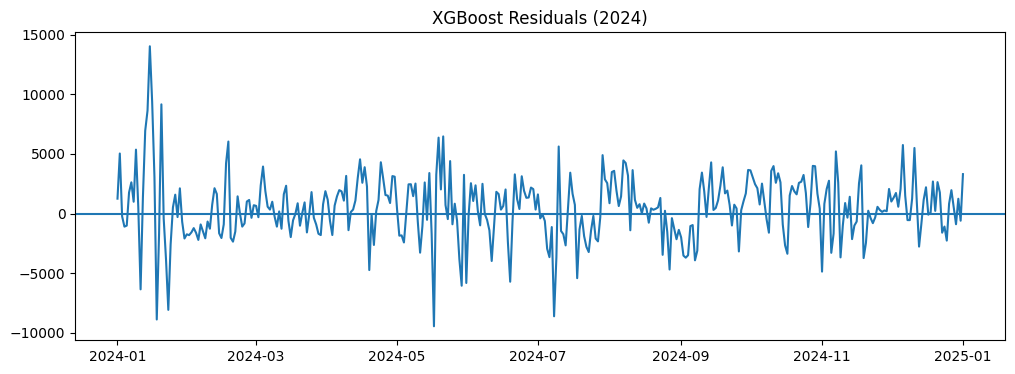

In [65]:
resid = test_aligned["actual"] - test_aligned["xgb"]

plt.figure(figsize=(12,4))
plt.plot(test_aligned["period"], resid)
plt.axhline(0)
plt.title("XGBoost Residuals (2024)")
plt.show()


In [ ]:
#summer vs non summer usage, texas specific
tmp = test_aligned.copy()
tmp["month"] = tmp["period"].dt.month

summer = tmp[tmp["month"].isin([6,7,8])]
non_summer = tmp[~tmp["month"].isin([6,7,8])]

pd.DataFrame({
    "MAE": [
        mean_absolute_error(summer["actual"], summer["xgb"]),
        mean_absolute_error(non_summer["actual"], non_summer["xgb"])
    ]
}, index=["Summer", "Non-summer"])


,MAE
Summer,1875.949856
Non-summer,2078.119711


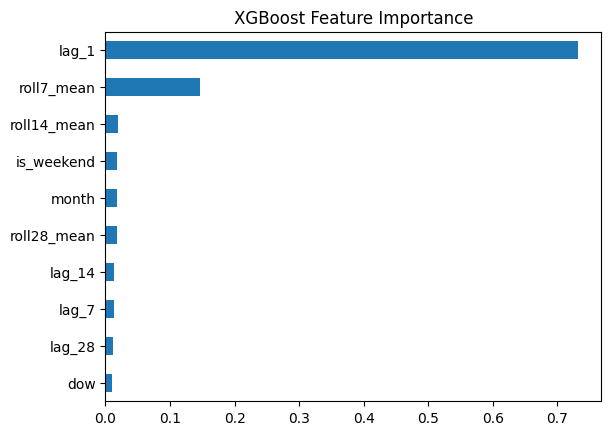

In [69]:
import pandas as pd

fi = pd.Series(
    xgb.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)


fi.head(10).plot(kind="barh", title="XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

